# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [7]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)
display(user_log)

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Data Exploration 

The next cells explore the data set.

In [5]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [8]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [9]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [10]:
user_log.count()

10000

In [11]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [12]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

# Calculating Statistics by Hour

In [13]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [14]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [15]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14')

In [16]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [17]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  249|
|   2|  216|
|   3|  228|
|   4|  251|
|   5|  339|
|   6|  462|
|   7|  479|
|   8|  484|
|   9|  430|
|  10|  362|
|  11|  295|
|  12|  257|
|  13|  248|
|  14|  369|
|  15|  375|
|  16|  456|
|  17|  454|
|  18|  382|
|  19|  302|
+----+-----+
only showing top 20 rows



In [18]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

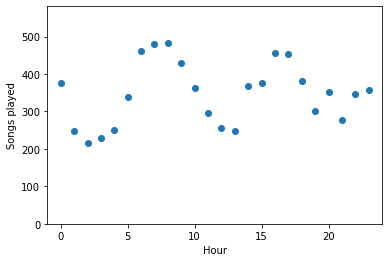

In [19]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [20]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [21]:
user_log_valid.count()

10000

In [22]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [23]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [37]:
user_log_invalid = user_log_valid.filter(user_log_valid["userId"] == "")

In [38]:
user_log_invalid.count()

0

In [24]:
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [25]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   3|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [26]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [27]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [28]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [29]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14', downgraded=0)

In [30]:
from pyspark.sql import Window

In [31]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [32]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [33]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

## Functions

In the previous video, we've used a number of functions to manipulate our dataframe. Let's take a look at the different type of functions and their potential pitfalls.

## General functions

We have used the following general functions that are quite similar to methods of pandas dataframes:

  - `select()`: returns a new DataFrame with the selected columns
  - `filter()`: filters rows using the given condition
  - `where()`: is just an alias for filter()
  - `groupBy()`: groups the DataFrame using the specified columns, so we can run aggregation on them
  - `sort()`: returns a new DataFrame sorted by the specified column(s). By default the second parameter 'ascending' is True.
  - `dropDuplicates()`: returns a new DataFrame with unique rows based on all or just a subset of columns
  - `withColumn()`: returns a new DataFrame by adding a column or replacing the existing column that has the same name. The first parameter is the name of the new column, the second is an expression of how to compute it.

## Aggregate functions

Spark SQL provides built-in methods for the most common aggregations such as `count()`, `countDistinct()`, `avg()`, `max()`, `min()`, etc. in the pyspark.sql.functions module. These methods are not the same as the built-in methods in the Python Standard Library, where we can find min() for example as well, hence you need to be careful not to use them interchangeably.

In many cases, there are multiple ways to express the same aggregations. For example, if we would like to compute one type of aggregate for one or more columns of the DataFrame we can just simply chain the aggregate method after a `groupBy()`. If we would like to use different functions on different columns, `agg()` comes in handy. For example `agg({"salary": "avg", "age": "max"})` computes the average salary and maximum age.

## User defined functions (UDF)

In Spark SQL we can define our own functions with the udf method from the pyspark.sql.functions module. The default type of the returned variable for UDFs is string. If we would like to return an other type we need to explicitly do so by using the different types from the pyspark.sql.types module.

## Window functions

Window functions are a way of combining the values of ranges of rows in a DataFrame. When defining the window we can choose how to sort and group (with the partitionBy method) the rows and how wide of a window we'd like to use (described by rangeBetween or rowsBetween).